<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/art_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Art-Images-Classification



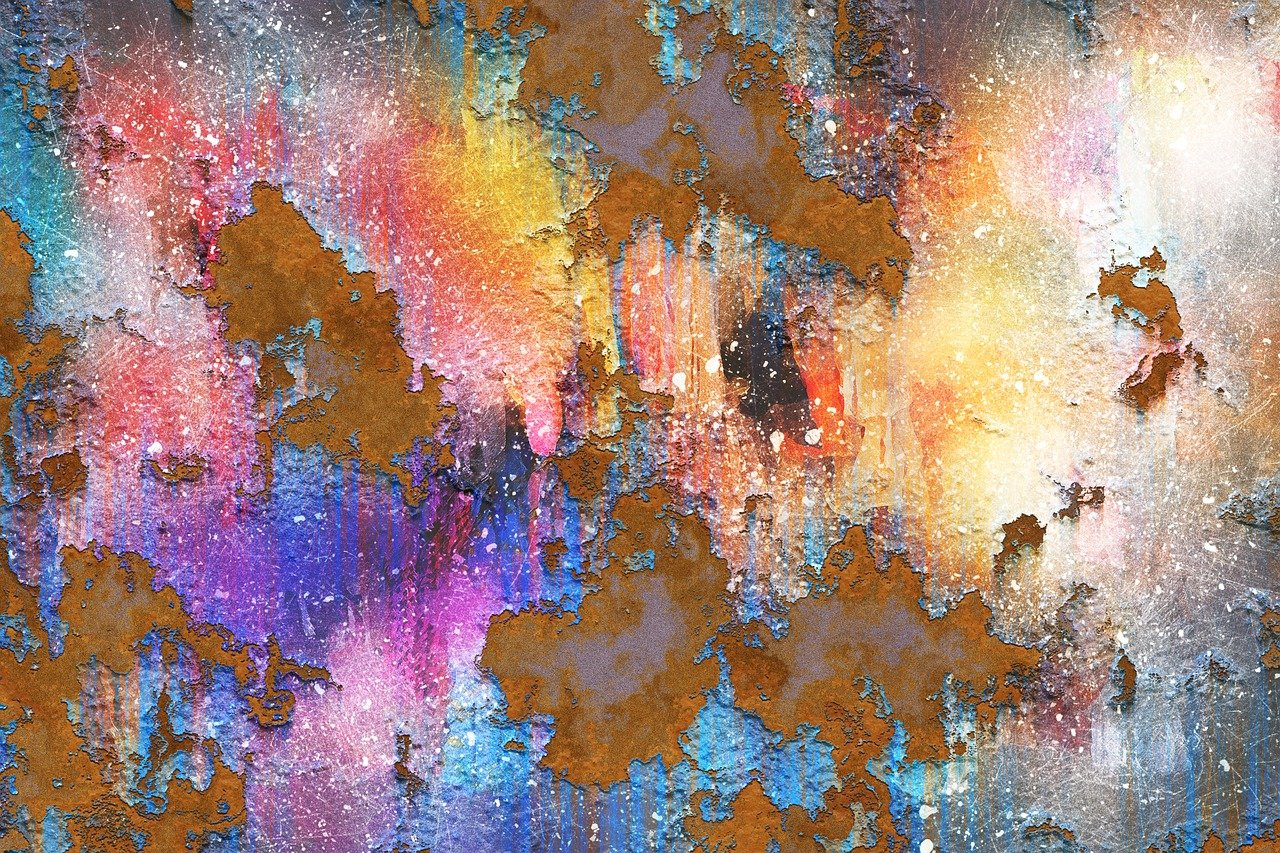

Dataset to classify different art styles using deep learning technique using Pythor.

## Let's begin by installing and importing the required libraries.

In [375]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split, WeightedRandomSampler
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## 1- Find a Datasetet

In [3]:
! pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
data_url = 'https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving'

In [256]:
od.download(data_url)

Skipping, found downloaded files in "./art-images-drawings-painting-sculpture-engraving" (use force=True to force download)


In [456]:
data_dir = 'art-images-drawings-painting-sculpture-engraving'

In [457]:
print(os.listdir(data_dir))

['dataset', 'musemart']


In [458]:
c_datadir = 'art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated'

In [459]:
print(os.listdir(c_datadir))

['validation_set', 'training_set']


In [460]:
classes = os.listdir(data_dir + "/dataset/dataset_updated")
classes

['validation_set', 'training_set']

In [461]:
#dataset = ImageFolder(c_datadir)

In [462]:
training_classes = os.listdir(c_datadir + "/training_set")
training_classes

['iconography', 'painting', 'sculpture', 'drawings', 'engraving']

In [463]:
for cls in os.listdir(c_datadir + "/training_set"):
  print(cls, ':', len(os.listdir(c_datadir + "/training_set"+'/' + cls)))


iconography : 2079
painting : 2128
sculpture : 1745
drawings : 1107
engraving : 760


In [464]:
training_dataset = ImageFolder(c_datadir + "/training_set", tt.ToTensor())
training_dataset

Dataset ImageFolder
    Number of datapoints: 7819
    Root location: art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set
    StandardTransform
Transform: ToTensor()

In [465]:
trainset_size = len(training_dataset)
trainset_size

7819

In [466]:
#train_imag = ImageFolder(c_datadir + "/training_set")

In [467]:
#trainset_size = len(training_dataset)
#trainset_size

In [468]:
#validation_classes = os.listdir(c_datadir + "/validation_set")
#validation_classes

In [469]:
#for cls in os.listdir(c_datadir + "/validation_set"):
  #print(cls, ':', len(os.listdir(c_datadir + "/validation_set"+'/' + cls)))

In [470]:
#validation_dataset = ImageFolder(c_datadir + "/validation_set", tt.ToTensor())
#validation_dataset

In [471]:
import random
import numpy as np

In [472]:
import cv2
from PIL import Image

In [473]:
train_imgs_painting = 'art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting'


In [474]:
#paint_train_size = len(train_imgs_painting)
#paint_train_size

In [475]:
def get_traing_image(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = img_bgr[:,:,::-1]
    return img_rgb

def plot_traing_images(n_imgs, data_fold = train_imgs_painting):
    fnames = random.sample(os.listdir(data_fold), n_imgs)

    size = np.sqrt(n_imgs)
    if int(size)*int(size) < n_imgs:
        size = int(size) + 1

    plt.figure(figsize = (10, 10))

    for ind in range(n_imgs):
        plt.subplot(size, size, ind+1)
        img = get_traing_image(os.path.join(data_fold, fnames[ind]))

        plt.imshow(img)
        plt.axis('off')
    plt.show()

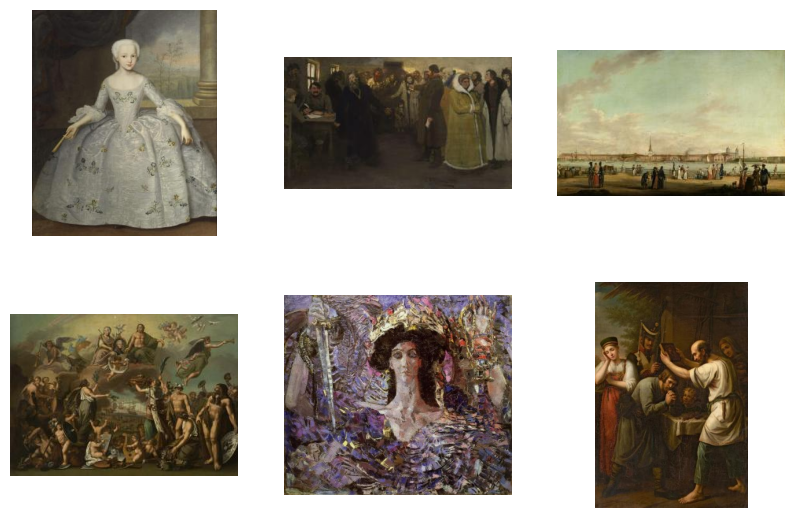

In [477]:
plot_traing_images(6, train_imgs_painting)

In [479]:
val_imgs_iconography = 'art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/validation_set/iconography'

In [480]:
def get_val_image(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = img_bgr[:,:,::-1]
    return img_rgb

def plot_val_images(n_imgs, data_fold = val_imgs_iconography):
    fnames = random.sample(os.listdir(data_fold), n_imgs)

    size = np.sqrt(n_imgs)
    if int(size)*int(size) < n_imgs:
        size = int(size) + 1

    plt.figure(figsize = (10, 10))

    for ind in range(n_imgs):
        plt.subplot(size, size, ind+1)
        img = get_val_image(os.path.join(data_fold, fnames[ind]))

        plt.imshow(img)
        plt.axis('off')
    plt.show()

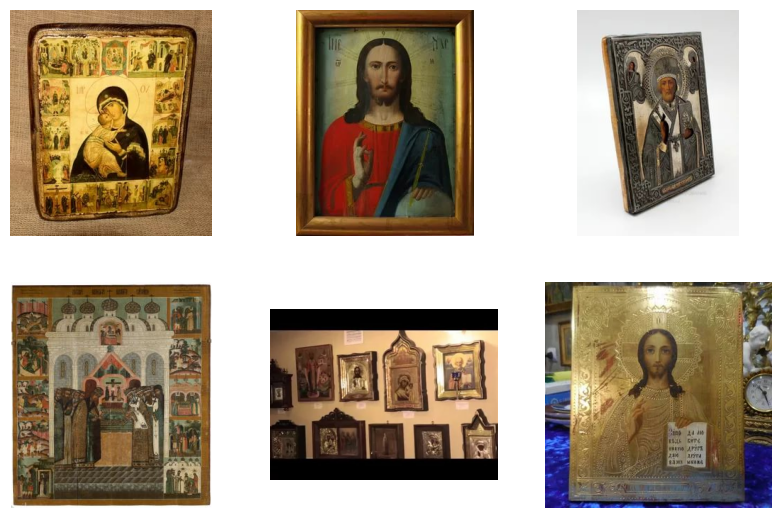

In [ ]:
plot_val_images(6, val_imgs_iconography)

## Data transforms (normalization & data augmentation)

In [481]:
#image_size = 128
batch_size = 128
#latent_size = 128
#clip_value = 0.01
#n_critic = 5

In [371]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
#valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

### PyTorch datasets

In [330]:
class CustomDataset(Dataset):
    def __init__(self, fold_path, transforms):
        super().__init__()
        self.fold_path = fold_path
        self.transforms = transforms
        self.img_names = os.listdir(fold_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.fold_path + '/' + self.img_names[idx]

        try:
            img = Image.open(img_path)
            img = self.transforms(img)
            return img, 0
        except:
            return None

# Dont load invalid or corrupt images
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
#def is_valid(file_path):
    # Add custom logic to determine if the file is valid
    # For example, check file extension or other criteria
    #valid_extensions = ['.jpg', '.png', '.jpeg']
    #_, file_extension = os.path.splitext(file_path)
    #return file_extension.lower() in valid_extensions



In [ ]:
#val_pct = 0.1
#val_size = int(val_pct * len(training_dataset))
#train_size = int(len(training_dataset) - val_size)

#train_size, val_size

In [482]:
val_pct = 0.1
val_size = int(val_pct * trainset_size)
train_size = int(trainset_size - val_size)

train_size, val_size

(7038, 781)

In [483]:
torch.manual_seed(123)

In [484]:
train_ds, valid_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(7038, 781)

In [ ]:
#train_ds = training_dataset, train_tfms
#train_ds

In [ ]:
#from torch.utils.data import random_split

#train_ds, valid_ds = random_split(training_dataset, [train_size, val_size])
#len(train_ds), len(valid_ds)

In [ ]:
#valid_ds = validation_dataset, valid_tfms
#valid_ds

In [179]:
#train_ds = ImageFolder(c_datadir + '/training_set',train_tfms)
#train_ds

In [104]:
#valid_ds = ImageFolder(c_datadir + '/validation_set',valid_tfms)
#valid_ds

In [331]:
#train_ds = CustomDataset(c_datadir + '/training_set', train_tfms)

In [106]:
#valid_ds = CustomDataset(c_datadir + '/training_set',valid_tfms)

In [107]:
#valid_ds = CustomDataset(c_datadir + '/validation_set',valid_tfms)
#valid_ds

### PyTorch data loaders

In [497]:
targets = [training_dataset.targets[i] for i in train_ds.indices]
img_count = np.unique(targets, return_counts=True)[1]
weight = 1./img_count
img_weight = weight[targets]
sampler = WeightedRandomSampler(img_weight,len(img_weight),replacement=True)

In [498]:
train_dl = DataLoader(train_ds, batch_size, sampler=sampler, num_workers=0, pin_memory=True)
#train_dl

In [499]:
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=0, pin_memory=True)
#valid_dl

In [335]:
#train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [336]:
#valid_dl = DataLoader(valid_ds, batch_size, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [488]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

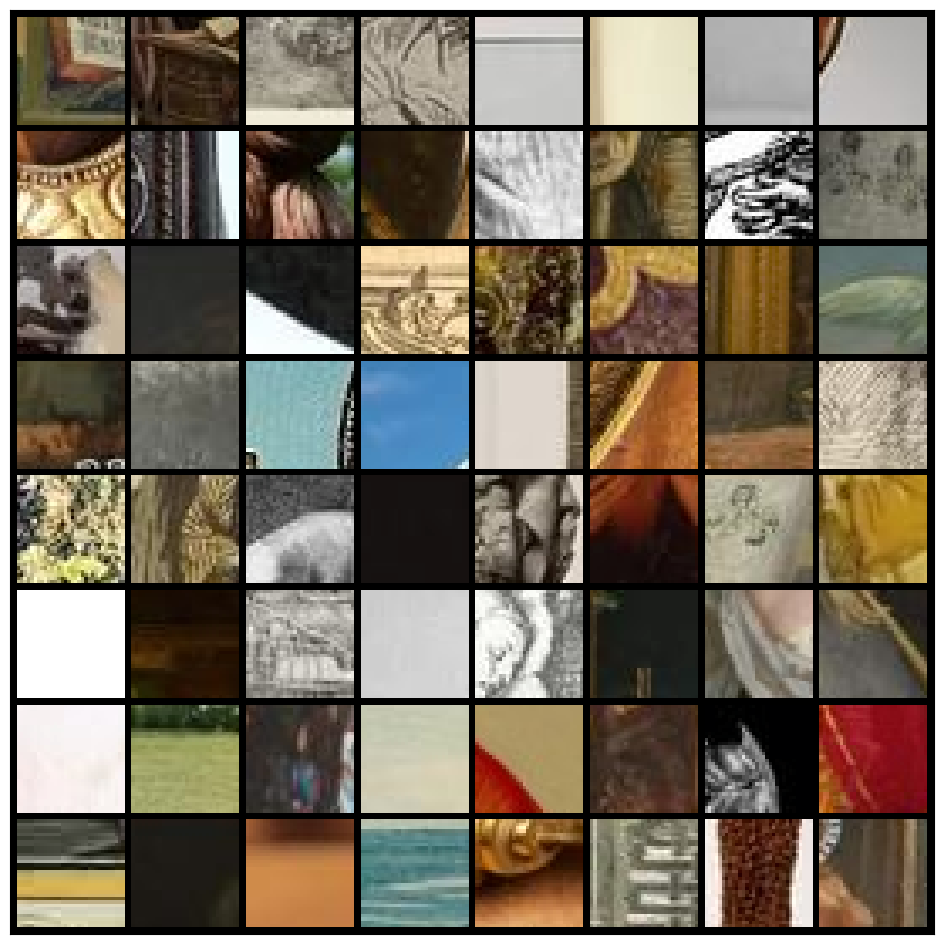

In [ ]:
show_batch(train_dl)

## Training on GPU

In [500]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [490]:
device = get_default_device()
device

device(type='cuda')

In [491]:
#for images, labels in train_dl:
    #print(images.shape)
    #images = to_device(images, device)
    #print(images.device)
    #break

In [492]:
#DeviceDataLoader.reshape(valid_dl, ([32, 3, 32, 32]))

In [493]:
#for images, labels in valid_dl:
    #print(images.shape)
    #images = to_device(images, device)
    #print(images.device)
    #break

In [501]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

In [502]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [515]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

UnidentifiedImageError: ignored

In [383]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [384]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [385]:
model = to_device(ResNet9(3, len(training_classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight

Parameter containing:
tensor([[[[ 1.8069e-01,  7.7774e-02,  1.3220e-01],
          [-1.8262e-01,  8.4795e-02,  7.4749e-02],
          [ 1.3537e-01, -1.6121e-01, -1.3020e-01]],

         [[ 1.8911e-01,  1.1825e-01, -1.7815e-01],
          [-1.6876e-01, -7.3342e-02,  1.8340e-01],
          [-5.3656e-02, -2.4362e-02,  3.6307e-02]],

         [[ 9.2263e-02,  4.1143e-02,  8.6783e-03],
          [ 4.7880e-03,  1.3053e-01,  1.8701e-01],
          [-1.8270e-01,  5.8688e-02, -7.8858e-02]]],


        [[[-1.5665e-01,  1.3923e-01, -1.0312e-01],
          [-4.8358e-02,  5.7603e-02,  1.2196e-01],
          [ 5.1560e-02, -1.6743e-01,  4.9889e-02]],

         [[ 8.3184e-02,  1.6598e-01, -2.9210e-02],
          [-5.6718e-02,  1.1312e-01,  1.1469e-01],
          [-1.8411e-01, -1.6145e-01, -1.2774e-01]],

         [[ 8.8955e-02, -3.5144e-02, -1.1368e-01],
          [ 4.8172e-02,  7.2094e-02,  1.6950e-01],
          [-1.6129e-01, -1.5177e-01,  9.8143e-03]]],


        [[[ 1.3530e-01,  1.8970e-01,  8.0628

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([5, 512])
torch.Size([5])


In [ ]:
#for batch in train_dl:
  #images, label = batch
  #print('images.shape', images.shape)
  #print('images.device',images.device)
  #preds = model(images)
  #print('preds.shape',preds.shape)
  #break

## Training the model

In [386]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [387]:
valid_dl

In [ ]:
steps_per_epoch = len(train_dl)//batch_size
steps_per_epoch

validation_steps = len(valid_dl)//batch_size
validation_steps

0

In [ ]:
#def collate_fn(batch):
  #return {
      #'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      #'labels': torch.tensor([x['labels'] for x in batch])
#}

#DataLoader(..., collate_fn=collate_fn)

In [397]:
history = [evaluate(model, valid_dl)]
history

UnidentifiedImageError: ignored

In [ ]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import jovian

In [ ]:
project_name = 'art_classication'

In [ ]:
jovian.commit(project = project_name)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
